# Illustration of pruning
This notebook shows how the different pruning rules will affect where the synapses are located on the dendritic tree. 
f1 -- remove a fraction of all synapses
mu2 -- remove synapses between pairs of neurons connected by too few synapses
softMax -- reduce the number of synapses between neuron pairs with a lot of synapses
distDep -- distance dependent pruning (dependent on distance to soma along dendrite)
a3 -- remove a fraction of all the synapses

In [1]:
import os
import snudda

# Check if the user has the updated BasalGangliaData installed, if not use the old data provided
bg_path = os.path.join("..", "..", "..", "BasalGangliaData", "data")
if os.path.isdir(bg_path):
    snudda_data = bg_path
else:
    snudda_data = os.path.join(os.path.dirname(snudda.__file__), "data")
    
print(f"Using SNUDDA_DATA = {snudda_data}")

Using SNUDDA_DATA = ../../../BasalGangliaData/data


In [2]:
network_path = os.path.join("networks", "SynapsePruning")
number_of_neurons = 2000
rc = None  # Running in serial for now

In [3]:
import os

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

from snudda.core import Snudda

In [4]:
!./start_ipcluster.sh 4

Sleeping 20 seconds to wait for workers to start
2024-02-12 14:13:43.038 [IPClusterStart] Starting ipcluster with [daemonize=False]
2024-02-12 14:13:43.259 [IPController] Hub listening on tcp://127.0.0.1:39499 for registration.
2024-02-12 14:13:43.260 [IPController] Hub using DB backend: DictDB
2024-02-12 14:13:43.514 [IPController] hub::created hub
2024-02-12 14:13:43.514 [IPController] writing connection info to /home/hjorth/HBP/Snudda/examples/notebooks/.ipython/profile_default/security/ipcontroller-client.json
2024-02-12 14:13:43.515 [IPController] writing connection info to /home/hjorth/HBP/Snudda/examples/notebooks/.ipython/profile_default/security/ipcontroller-engine.json
2024-02-12 14:13:43.515 [IPController] task::using Python leastload Task scheduler
2024-02-12 14:13:43.528 [task] Task scheduler started [leastload]
2024-02-12 14:13:43.528 [broadcast-0] BroadcastScheduler 0 started
2024-02-12 14:13:43.529 [IPController] Heartmonitor beating every 3000ms
2024-02-12 14:13:43.530

In [5]:
from snudda import SnuddaInit
struct_def = {"Striatum": number_of_neurons }

si = SnuddaInit(network_path=network_path, struct_def=struct_def, random_seed=12345, snudda_data=snudda_data)

Adding Striatum with 2000 neurons (stay_inside=False)
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Adding neurons: ChIN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/chin
Adding neurons: LTS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/lts
No directory $SNUDDA_DATA/neurons/striatum/ngf, skipping NGF cells.
Writing networks/SynapsePruning/network-config.json


In [6]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, rc=rc)
sp.place()

Reading SNUDDA_DATA=../../../BasalGangliaData/data from networks/SynapsePruning/network-config.json
Generating 8048 points for networks/SynapsePruning/mesh/Striatum-cube-mesh-0.00029179512939439816.obj
n_points = 7664, previous close_pairs = 13144
n_points = 7301, previous close_pairs = 10693
n_points = 6957, previous close_pairs = 8833
n_points = 6633, previous close_pairs = 7292
n_points = 6330, previous close_pairs = 6110
n_points = 6048, previous close_pairs = 5088
n_points = 5785, previous close_pairs = 4292
n_points = 5543, previous close_pairs = 3556
n_points = 5321, previous close_pairs = 2974
n_points = 5121, previous close_pairs = 2543
n_points = 4941, previous close_pairs = 2163
n_points = 4781, previous close_pairs = 1814
n_points = 4638, previous close_pairs = 1522
n_points = 4593, previous close_pairs = 1259
n_points = 3420, previous close_pairs = 1173
Filtering 3420 points..
Filtering, keeping inside points: 2446 / 3420


In [7]:
# Run detect and prune in parallel by passing rc
from ipyparallel import Client
u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
rc = Client(url_file=u_file, timeout=120, debug=False)

In [8]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()
Snudda.cleanup_workers_rc(rc=rc)

Reading SNUDDA_DATA=../../../BasalGangliaData/data from networks/SynapsePruning/network-config.json
importing SnuddaDetect from snudda.detect.detect on engine(s)
importing ProjectionDetection from snudda.detect.projection_detection on engine(s)
Suppressing printouts for hyper voxels that complete in < 100 seconds.


In [9]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, keep_files=True, rc=rc)
sp.prune()
Snudda.cleanup_workers_rc(rc=rc)

output_file = os.path.join(network_path, "network-synapses.hdf5")
save_prune_all = os.path.join(network_path, "network-synapses-prune-all.hdf5")
os.rename(output_file, save_prune_all)

No file networks/SynapsePruning/pruning_merge_info.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (877271/17064512 synapses, 5.1% kept): 25.7s
prune_synapses_parallel (26/187 gap_junctions, 13.9% kept): 0.0s


# Pruning different version

Now for the tricky bit, we need to first create multiple config files that only keep some of the pruning steps.

In [10]:
import json
orig_config_file = os.path.join(network_path, "network-config.json")
with open(orig_config_file, "r") as f:
    orig_config = json.load(f)

In [11]:
config_options = ["a3", "distPruning", "f1", "softMax", "mu2"]
remaining_config_options = config_options.copy()
modified_config = orig_config.copy()

orig_config_copy = os.path.abspath(os.path.join(network_path, f"network-config-{'-'.join(config_options)}.json"))
orig_network_copy = os.path.abspath(os.path.join(network_path, f"network-synapses-{'-'.join(config_options)}.hdf5"))

if not os.path.exists(orig_network_copy):
    os.symlink("network-synapses-prune-all.hdf5", orig_network_copy)
    
if not os.path.exists(orig_config_copy):
    os.symlink("network-config.json", orig_config_copy)

config_file_list = [orig_config_copy]
output_file_list = [orig_network_copy]

for param in config_options[::-1]:
    for neuron_pair in modified_config["connectivity"]:
        for con_type in modified_config["connectivity"][neuron_pair]:
            modified_config["connectivity"][neuron_pair][con_type]["pruning"][param] = None
            
            if "pruning_other" in modified_config["connectivity"][neuron_pair][con_type]:
                modified_config["connectivity"][neuron_pair][con_type]["pruning_other"][param] = None

            
    remaining_config_options = remaining_config_options[:-1]
    
    if len(remaining_config_options) > 0:
        opt_name = "-".join(remaining_config_options)
    else:
        opt_name = "NONE"
    
    config_file_name = os.path.join(network_path, f"network-config-{opt_name}.json")
    output_file_name = os.path.join(network_path, f"network-synapses-{opt_name}.hdf5")
                                    
    config_file_list.append(config_file_name)
    output_file_list.append(output_file_name)

    with open(config_file_name, "w") as f:
        json.dump(modified_config, f, indent=4)

In [12]:
for config_file, output_file_new in zip(config_file_list, output_file_list):
    print(f"Processing {config_file}")
    sp = SnuddaPrune(network_path=network_path, keep_files=True, config_file=config_file, rc=rc)
    sp.prune()
    os.rename(output_file, output_file_new)
    Snudda.cleanup_workers_rc(rc=rc)

Processing /home/hjorth/HBP/Snudda/examples/notebooks/networks/SynapsePruning/network-config-a3-distPruning-f1-softMax-mu2.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (877271/17064512 synapses, 5.1% kept): 25.7s
prune_synapses_parallel (26/187 gap_junctions, 13.9% kept): 0.0s
Processing networks/SynapsePruning/network-config-a3-distPruning-f1-softMax.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (1931389/17064512 synapses, 11.3% kept): 24.0s
prune_synapses_parallel (42/187 gap_junctions, 22.5% kept): 0.0s
Processing networks/SynapsePruning/network-config-a3-distPruning-f1.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (1931389/17064512 synapses, 11.3% kept): 25.2s
prune_synapses_parallel (42/187 gap_junctions, 22.5% kept): 0.0s
Processing networks/SynapsePruning/network-config-a3-distPruning.json
importing SnuddaPrune from snudda.detect.prune on engine(s)
pr

Analysing /home/hjorth/HBP/Snudda/examples/notebooks/networks/SynapsePruning/network-synapses-a3-distPruning-f1-softMax-mu2.hdf5, synapses onto dSPN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1-softMax-mu2.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning-f1-softMax.hdf5, synapses onto dSPN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1-softMax.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning-f1.hdf5, synapses onto dSPN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning.hdf5, synapses onto dSPN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning.png
Analysing networks/SynapsePruning/network-synapses-a3.hdf5, synapses onto dSPN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3.png
Analysing networks/SynapsePruning

/tmp/ipykernel_165814/1214453573.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1-softMax-mu2.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning-f1-softMax.hdf5, synapses onto ChIN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1-softMax.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning-f1.hdf5, synapses onto ChIN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning-f1.png
Analysing networks/SynapsePruning/network-synapses-a3-distPruning.hdf5, synapses onto ChIN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3-distPruning.png
Analysing networks/SynapsePruning/network-synapses-a3.hdf5, synapses onto ChIN
Writing figure to networks/SynapsePruning/figures/synapse-locations-a3.png
Analysing networks/SynapsePruning/network-synapses-NONE.hdf5, synapses onto ChIN
Writing figure to networks/SynapsePruning/figures/synapse-locations-NONE.png
Analysing /home/hjorth/H

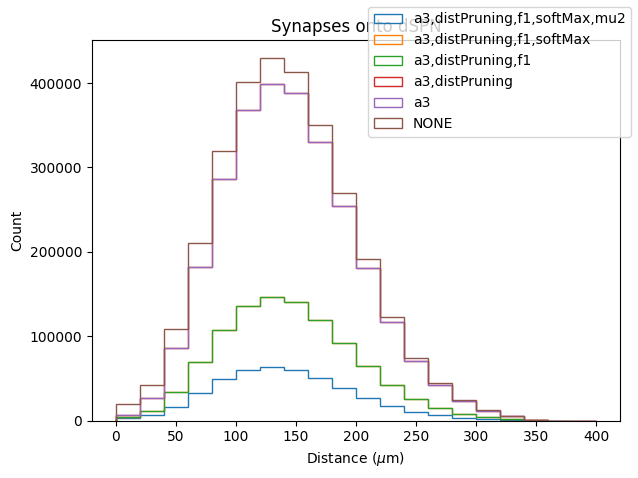

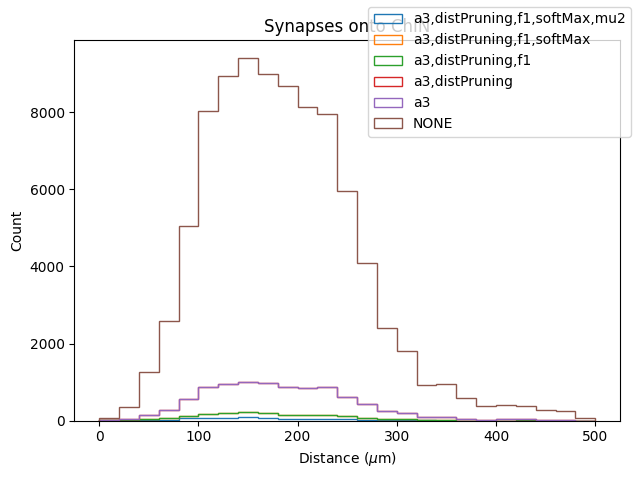

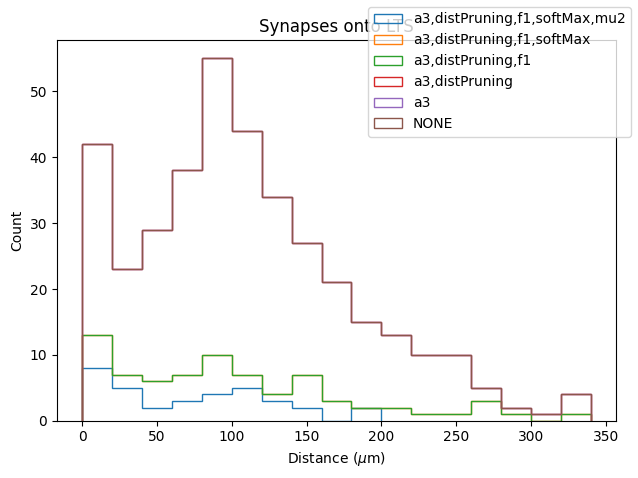

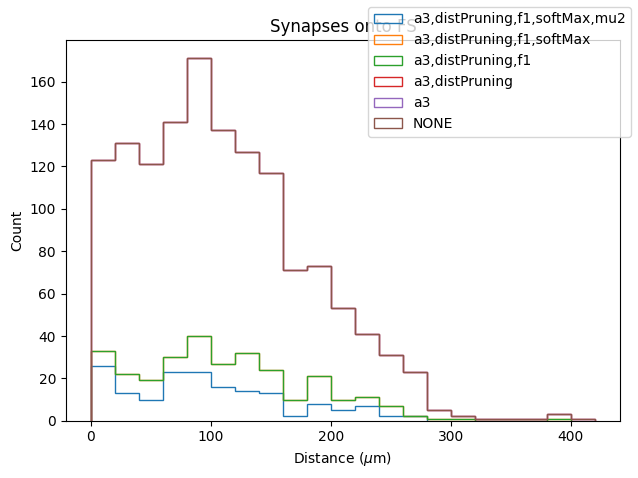

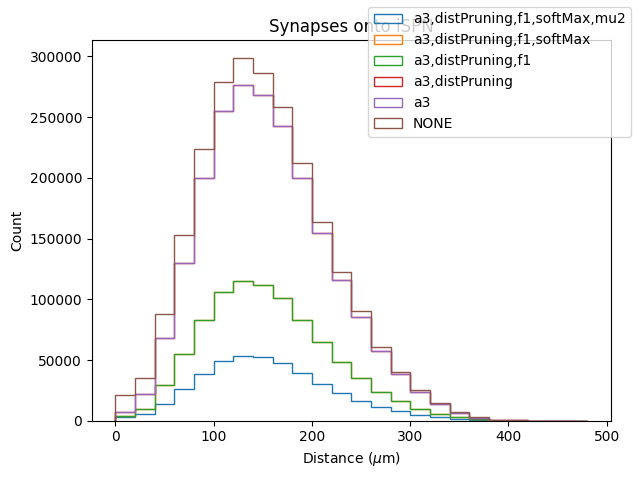

In [13]:
from snudda.analyse.analyse_synapse_location import AnalyseSynapseLocation

sa_list = []

for network_file_path in output_file_list:
    sa_list.append(AnalyseSynapseLocation(network_file_path))
    

neuron_types = sa_list[0].snudda_loader.get_neuron_types(return_set=True)
pre_type = None

for post_type in neuron_types:
    fig = None
    for sa in sa_list:
        print(f"Analysing {sa.snudda_loader.network_file}, synapses onto {post_type}")
        f_name = os.path.basename(sa.snudda_loader.network_file).replace("network-synapses-","")
        fig = sa.plot_synapse_distance_to_soma(pre_type=pre_type, post_type=post_type, figure=fig, show_plot=False, 
                                               title=f"Synapses onto {post_type}", label=f_name.replace(".hdf5", "").replace("-", ","),
                                               fig_path=os.path.join(network_path, "figures", f'synapse-locations-{f_name.replace(".hdf5", ".png")}'))
    fig.tight_layout()
    fig.legend(loc="upper right")
    fig.show()

In [14]:
!ipcluster stop

2024-02-12 14:19:31.232 [IPClusterStop] Stopping cluster 
2024-02-12 14:19:31.233 [IPClusterStop] Stopping controller
2024-02-12 14:19:31.363 [IPClusterStop] Stopping engine(s): 1707743624
